# Importacao Bibliotecas

In [60]:
#importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.ensemble import(AdaBoostClassifier,
                             RandomForestClassifier,
                              GradientBoostingClassifier)

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from scipy import stats

from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   RobustScaler,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   )

from sklearn.model_selection import (train_test_split as tts,
                                     RandomizedSearchCV as rs,
                                     cross_validate as cv)

from sklearn.dummy import DummyClassifier

from sklearn import set_config

from sklearn.linear_model import LogisticRegression

from lightgbm import  LGBMClassifier

from sklearn.neural_network import  MLPClassifier

from yellowbrick.classifier import (confusion_matrix,
                                  PrecisionRecallCurve,
                                    ROCAUC)
import warnings

warnings.filterwarnings("ignore")

set_config("diagram")

sns.set(style = 'whitegrid')

# Funcoes para uso do case

In [2]:
# criando funcoes para metricas
def calculate_metrics(model, X, y):
        y_pred = model.predict(X)

        model_metrics = {
        'accuracy': metrics.accuracy_score(y, y_pred),
        'balanced_accuracy': metrics.balanced_accuracy_score(y, y_pred),
        'precision': metrics.precision_score(y, y_pred),
        'recall': metrics.recall_score(y, y_pred),
        'f1': metrics.f1_score(y, y_pred),
    }

        try:
            y_pred_proba = model.predict_proba(X)[:,1]
            model_metrics['roc-auc'] = metrics.roc_auc_score(y, y_pred_proba)
            return model_metrics
        except:
            return model_metrics

#extracao e tratamento e mudando de tipo de dados
def prep()->pd.DataFrame :
  df=pd.read_excel("/content/churn_data.xlsx")
  df["SeniorCitizen"]=df["SeniorCitizen"].astype("int16")
  df["tenure"]=df["tenure"].astype("int16")
  df["MonthlyCharges"]=df["MonthlyCharges"].astype("int16")
  df["TotalCharges"]=df["TotalCharges"].astype("int16")
  df.columns = df.columns.str.lower()
  df=df.sample(frac=1, random_state=101)


  return df

df=prep()

'''separando meu dataset em 2 diferentes, onde o holdoutset
vai ser utilizado no final como um dataset de avaliacao de modelo'''

hold_out=df.sample(n=1032,random_state=101).index

def splitdf()->pd.DataFrame:
  df_train=(df.loc[~df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  .drop(columns="customerid"))

  df_holdout=(df.loc[df.index.isin(hold_out)]
  .sample(frac=1, random_state=101)
  .reset_index(drop=True)
  .drop(columns="customerid"))

  return df_train, df_holdout

df_train,df_holdout=splitdf()

# EDA

In [62]:
# checando se existem valores faltantes no nosso dataset
df_train.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [4]:
'''analisando os valores de churn se estao com as mesma proporcao entre holdout
df_train '''
df_holdout.churn.value_counts()

No     736
Yes    296
Name: churn, dtype: int64

In [5]:
df_train.churn.value_counts()

No     4427
Yes    1573
Name: churn, dtype: int64

In [7]:
#checando duplicados na dataset de treino
df_train[df_train.duplicated(keep=False)].sort_values(df_train.columns.tolist())

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3080,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45,45,Yes
5250,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45,45,Yes
1524,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,45,45,No
4670,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,45,45,No
5305,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,45,45,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19,19,Yes
4434,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20,20,No
5473,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20,20,No
1901,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19,19,No


In [8]:
#analise descritiva do nosso dataset nas colunas numericas

describe=df_train.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75,0.90, 0.99])

describe.style.background_gradient(axis=None)

,seniorcitizen,tenure,monthlycharges,totalcharges
count,6000.000000,6000.000000,6000.000000,6000.000000
mean,0.165167,32.690667,64.505500,2299.839833
std,0.371362,24.588590,30.074891,2269.410846
min,0.000000,1.000000,18.000000,18.000000
1%,0.000000,1.000000,19.000000,19.000000
10%,0.000000,2.000000,20.000000,88.000000
25%,0.000000,9.000000,35.000000,415.000000
50%,0.000000,29.000000,70.000000,1413.500000
75%,0.000000,56.000000,89.000000,3813.000000
90%,1.000000,69.000000,102.000000,5991.600000


In [63]:
#analise descritiva do nosso dataset parte categorica
describe_ob=df_train.describe(exclude="number").T
describe_ob

,count,unique,top,freq
gender,6000,2,Male,3041
partner,6000,2,No,3094
dependents,6000,2,No,4212
phoneservice,6000,2,Yes,5430
multiplelines,6000,3,No,2867
internetservice,6000,3,Fiber optic,2647
onlinesecurity,6000,3,No,2973
onlinebackup,6000,3,No,2637
deviceprotection,6000,3,No,2612
techsupport,6000,3,No,2937


In [10]:
#separando as colunas numericas e colunas categoricas
cat_col=df_train.select_dtypes(exclude="number").columns
num_col=[col for col in df_train.columns if col not in cat_col ]

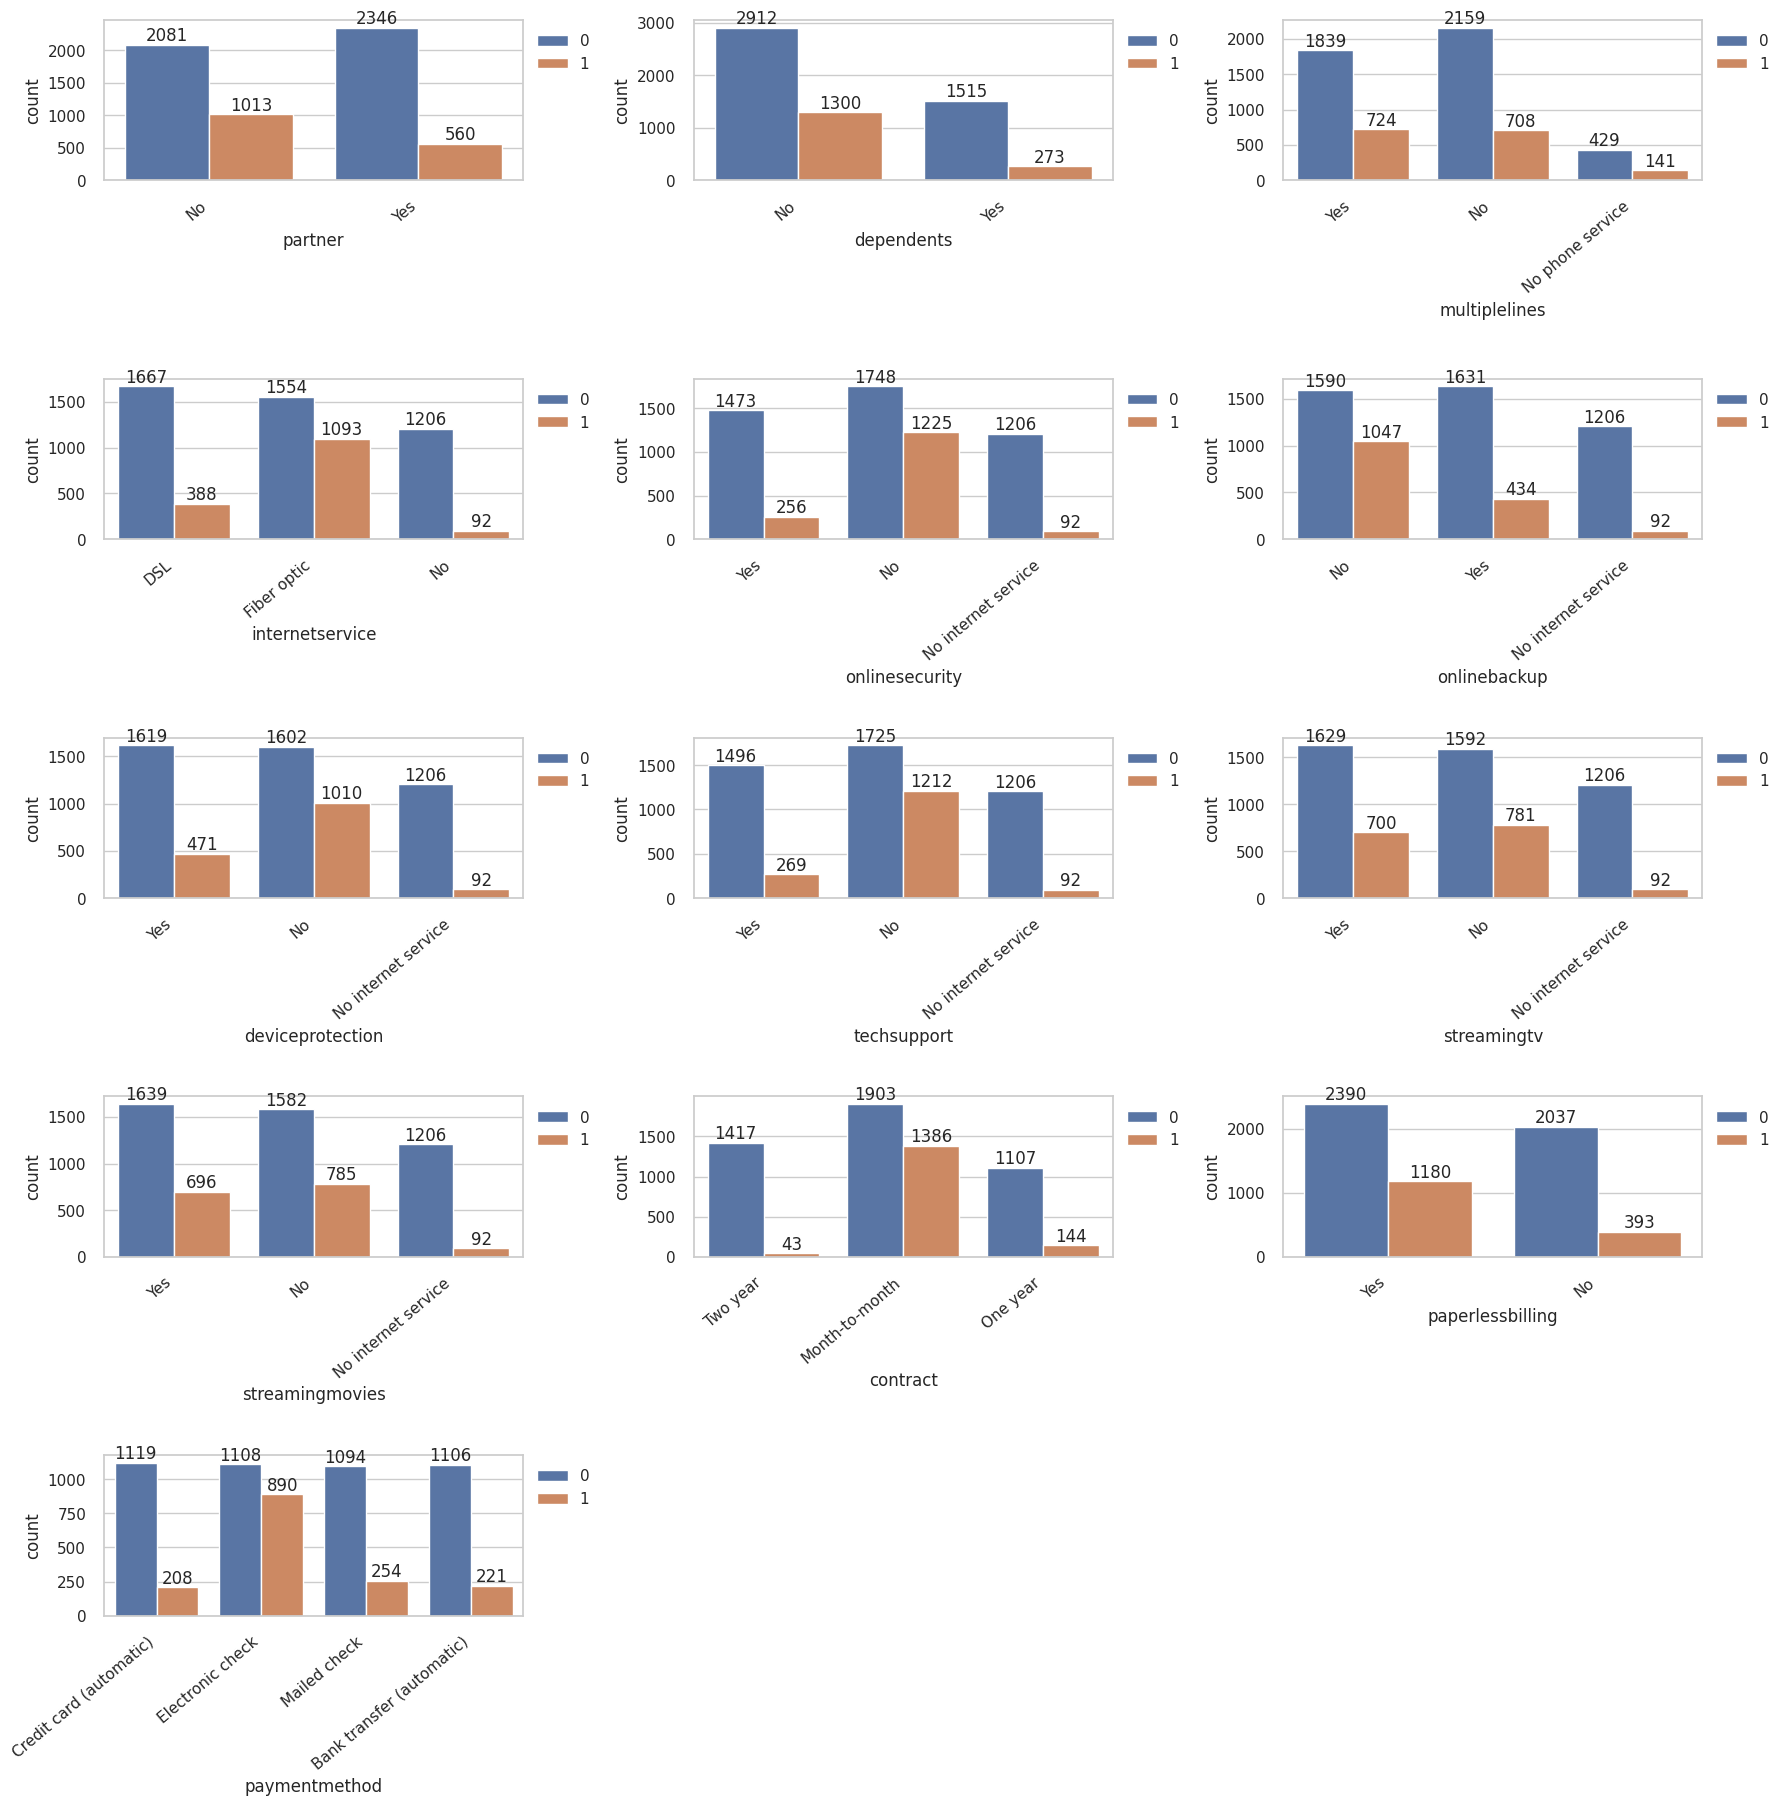

In [64]:
#plotagem de graficos para comparacao de variaveis categoricas x churn
plt.figure(figsize=(18,20))
for i, cat in enumerate(cat_col):
  ax=plt.subplot(6,3 , i+1)
  sns.countplot(data=df_train, x=cat, hue="churn")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  for label in ax.containers:
    ax.bar_label(label)
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.tight_layout()




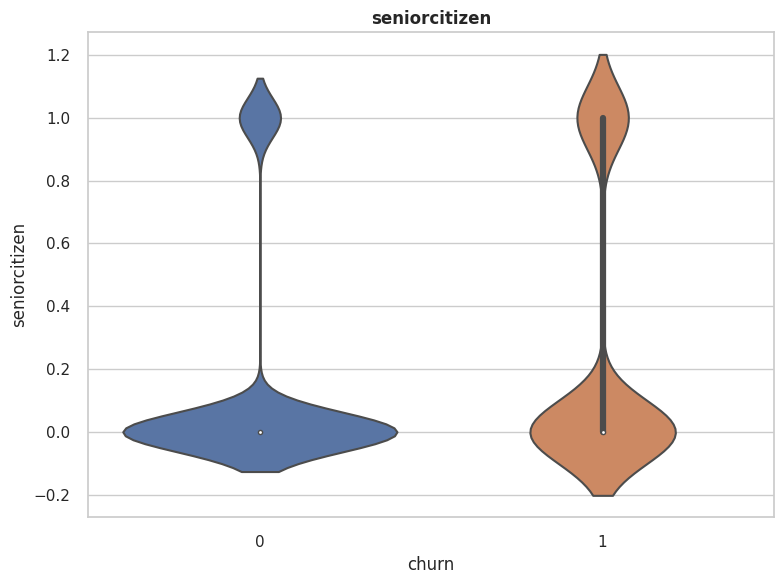

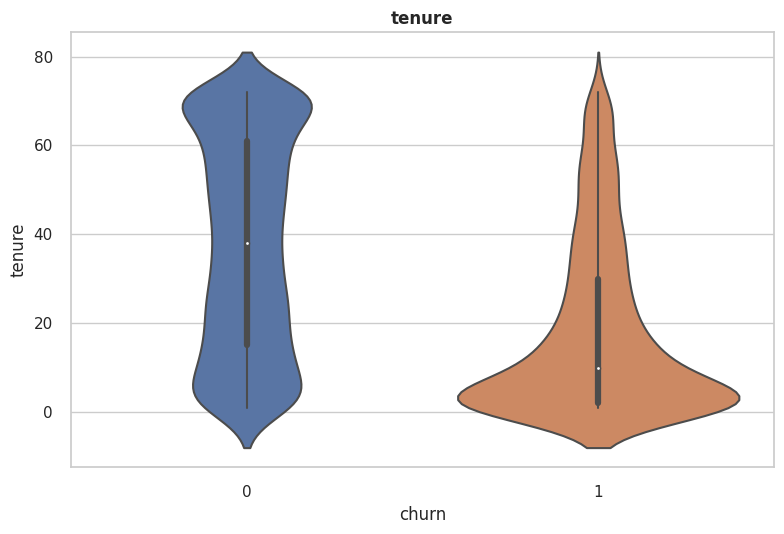

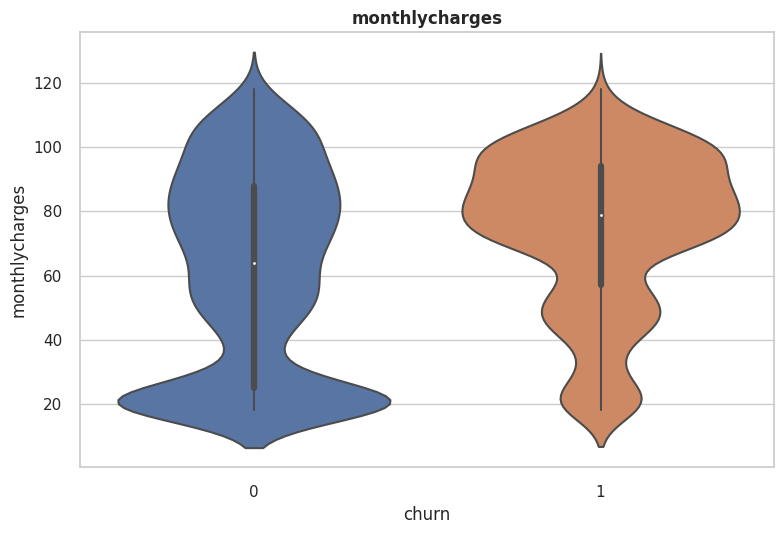

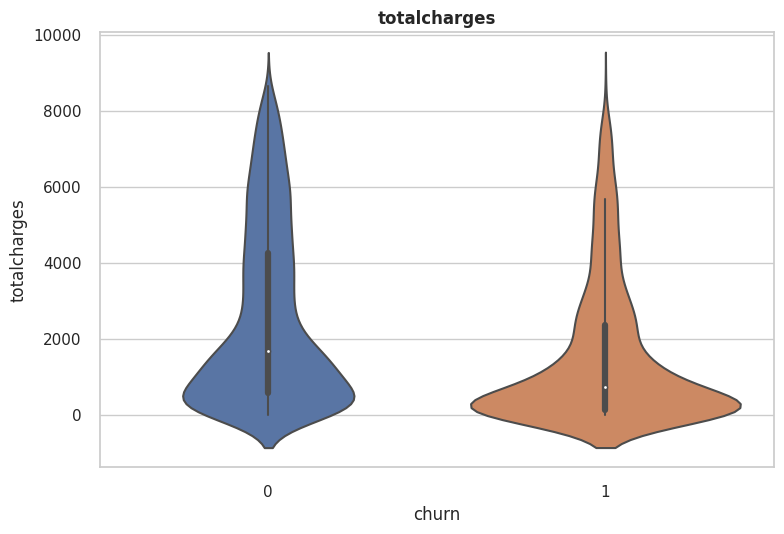

In [65]:
#violinplot para facilitar a visualizacao de como nosso Df esta distribuidos entre Churn e nao Churn
plt.figure(figsize=(8,6))
for col in num_col:
  sns.violinplot(data=df_train, x="churn", y=col , split=True)
  plt.title(col, weight="bold")
  plt.tight_layout()
  plt.show()

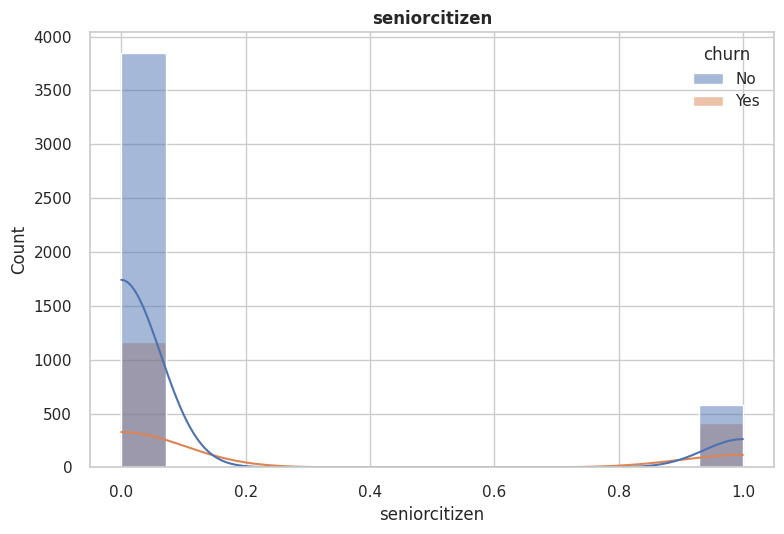

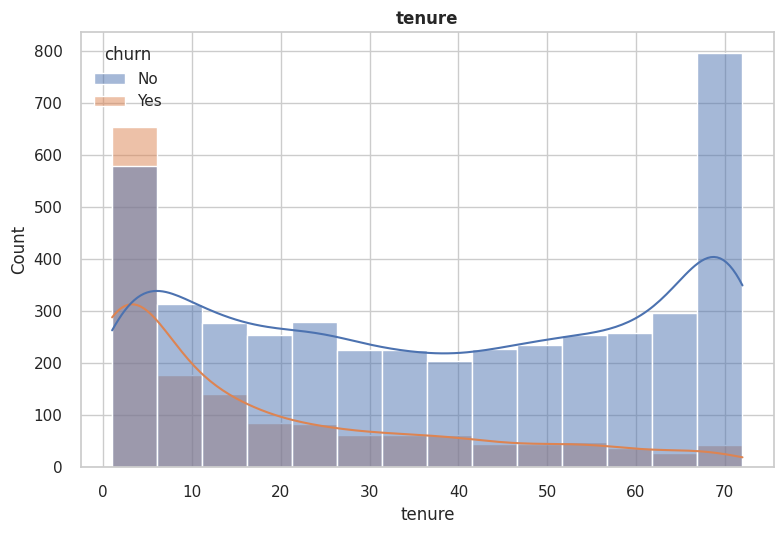

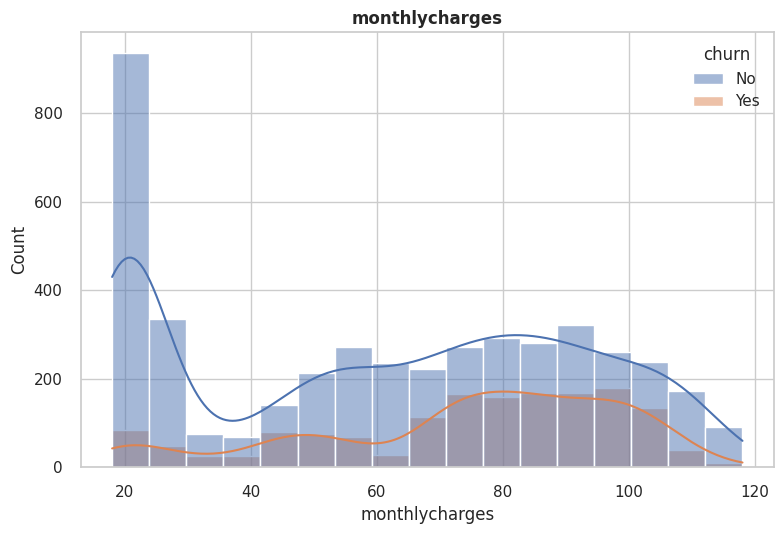

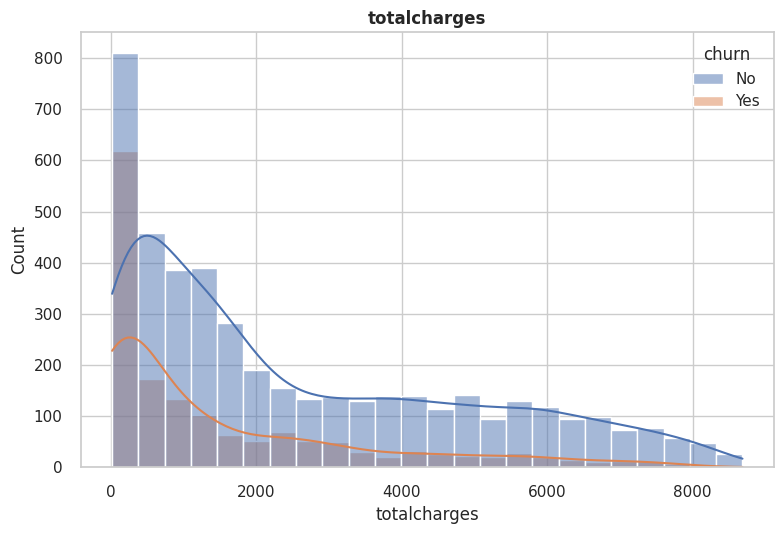

In [14]:
'''Plotagem de histograma para sobreposoto
para facilitar a comparacao da distribuicao entre CHURN x NAO CHURN'''
for col in num_col:
    sns.histplot(data=df_train, x=col, kde=True, hue="churn")
    plt.title(col,weight="bold")
    plt.tight_layout()
    plt.show()

# Analise estatisticas das variaveis

In [15]:
feature= "tenure"
a=df_train.loc[df_train.churn=="No", feature]
b=df_train.loc[df_train.churn=="Yes", feature]

stats.ttest_ind(a,b)

Ttest_indResult(statistic=28.970195626255894, pvalue=7.862071240143188e-173)

In [16]:
ttest_result={}
for num in num_col:
  a=df_train.loc[df_train.churn=="No", feature]
  b=df_train.loc[df_train.churn=="Yes", feature]
  pvalue=stats.ttest_ind(a,b).pvalue
  ttest_result[num]=pvalue

ttest_result

{'seniorcitizen': 7.862071240143188e-173,
 'tenure': 7.862071240143188e-173,
 'monthlycharges': 7.862071240143188e-173,
 'totalcharges': 7.862071240143188e-173}

In [17]:
pd.DataFrame([ttest_result]).T.round(5)

,0
seniorcitizen,0.0
tenure,0.0
monthlycharges,0.0
totalcharges,0.0


In [18]:
df_contingency=pd.crosstab(df_train.contract, df_train.churn)

In [19]:
chi_results={}

for cat in cat_col:
  df_contingency=pd.crosstab(df[cat], df.churn)
  pvalue=stats.chi2_contingency(df_contingency).pvalue
  chi_results[cat]=pvalue

chi_results

{'gender': 0.4904884707065509,
 'partner': 3.97379757451591e-36,
 'dependents': 2.0196592017051303e-42,
 'phoneservice': 0.34992398942431924,
 'multiplelines': 0.0035679273999811405,
 'internetservice': 5.831198962237274e-159,
 'onlinesecurity': 1.4006867477839222e-184,
 'onlinebackup': 7.776099238804965e-131,
 'deviceprotection': 1.9593887862403176e-121,
 'techsupport': 7.407807748843711e-180,
 'streamingtv': 1.324641113169159e-81,
 'streamingmovies': 5.353560421401324e-82,
 'contract': 7.326182186265472e-257,
 'paperlessbilling': 8.236203353962564e-58,
 'paymentmethod': 1.4263098511063342e-139,
 'churn': 0.0}

In [20]:
chi_value=pd.Series(chi_results).to_frame("p_value")
(chi_value
.sort_values("p_value", ascending=False)
.round(5)
.style.background_gradient())

,p_value
gender,0.490490
phoneservice,0.349920
multiplelines,0.003570
partner,0.000000
dependents,0.000000
paperlessbilling,0.000000
streamingtv,0.000000
streamingmovies,0.000000
deviceprotection,0.000000
onlinebackup,0.000000


# Modeling

In [21]:
enconde={"No":0,
         "Yes":1}

df_train["churn"]=df_train["churn"].map(enconde)

In [22]:
cat_col=[
          #'gender',
         'partner',
         'dependents',
         #'phoneservice',
         'multiplelines',
        'internetservice',
         'onlinesecurity',
         'onlinebackup',
         'deviceprotection',
        'techsupport',
         'streamingtv',
         'streamingmovies',
         'contract',
        'paperlessbilling',
         'paymentmethod',
         #'churn'
          ]

num_col
x=cat_col+num_col

y="churn"

In [51]:
df_train[y]

0       0
1       1
2       1
3       0
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: churn, Length: 6000, dtype: int64

In [52]:
x_train, x_test, y_train, y_test = tts( df_train[x], df_train[y], random_state=101, stratify=df_train[y])

In [53]:
# List com tuplas, onde, cada tupla, tem os 3 seguintes elementos:
# nome - transformador - variaveis
preprocessor=ColumnTransformer([
    ("scaler",RobustScaler(), num_col),
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_col)
])

In [76]:
pipe=Pipeline([
    ("preprocessing", preprocessor),
    ("model", LogisticRegression())
])

pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['partner', 'dependents',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model', LogisticRegression())])

In [55]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                                  ['seniorcitizen', 'tenure',
                                                   'monthlycharges',
                                                   'totalcharges']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['partner', 'dependents',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('model', LogisticRegression())])

In [56]:
#metricas de avaliacao  da Regressao Logistica

calculate_metrics(pipe, x_test, y_test)

{'accuracy': 0.7986666666666666,
 'balanced_accuracy': 0.7109649213540481,
 'precision': 0.6408668730650154,
 'recall': 0.5267175572519084,
 'f1': 0.5782122905027933,
 'roc-auc': 0.8318254641409857}

In [66]:
#treinamento e metricas usando random forest
pipe.set_params(model=RandomForestClassifier()).fit(x_train, y_train)
calculate_metrics(pipe, x_test, y_test)

{'accuracy': 0.7653333333333333,
 'balanced_accuracy': 0.6645841522028452,
 'precision': 0.5650793650793651,
 'recall': 0.4529262086513995,
 'f1': 0.5028248587570622,
 'roc-auc': 0.7982362987327921}

#Cross_validation

In [71]:
models = {
    'dummy': DummyClassifier(),
    'lr': LogisticRegression(class_weight='balanced'),
    'rf': RandomForestClassifier(class_weight='balanced'),
    'gbc': GradientBoostingClassifier()
}



In [82]:
results = []

for model_name, modelo in models.items():
  print(modelo)
  pipe.set_params(model=modelo).fit(x_train, y_train)
  result=calculate_metrics(pipe, x_test, y_test)
  results.append(result)

  print(results)







DummyClassifier()
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}]
LogisticRegression(class_weight='balanced')
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.74, 'balanced_accuracy': 0.7532772019832158, 'precision': 0.502454991816694, 'recall': 0.7811704834605598, 'f1': 0.6115537848605578, 'roc-auc': 0.8319311988709369}]
RandomForestClassifier(class_weight='balanced')
[{'accuracy': 0.738, 'balanced_accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc-auc': 0.5}, {'accuracy': 0.74, 'balanced_accuracy': 0.7532772019832158, 'precision': 0.502454991816694, 'recall': 0.7811704834605598, 'f1': 0.6115537848605578, 'roc-auc': 0.8319311988709369}, {'accuracy': 0.7673333333333333, 'balanced_accuracy': 0.668400946095975, 'precision': 0.5691823899371069, 'recall': 0.46055979643765904, 'f1': 0.509142053445851, 'roc-auc': 0.8002096305950336}]
GradientBoos

AttributeError: ignored